In [9]:
from torch_geometric.datasets import Planetoid#下载数据集用的
from torch_geometric.transforms import NormalizeFeatures
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures()) #transform预处理
print()
print(f' Dataset: {dataset} : ')
print('=========')
print(f' Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
data = dataset[0]# 获得第一个图对象
print()
print(data)
print('=========')

print(f'Number of nodes: {data.num_nodes}')
print (f'Number of edges: {data.num_edges}')
# 计算平均节点度
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int (data.train_mask. sum()) / data.num_nodes :.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f' Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')
# Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
# 总共有2708个点,每个点1433维,边是2维,共1-556条边,y是标签,每个点都有标签


 Dataset: Cora() : 
 Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
 Has self-loops: False
Is undirected: True


In [10]:
#可视化部分
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
def visualize(h,color) :
    # 数据降成两维显示
    z =TSNE(n_components=2).fit_transform(h. detach().cpu ().numpy())
    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])
    plt.scatter(z[:,0],z[:,1], s=70, c=color,cmap="Set2")
    plt.show()

In [11]:
import torch
from torch.nn import Linear
import torch.nn.functional as F

class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_features, hidden_channels)#两层全连接
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

model = MLP(hidden_channels=16)
print(model)

MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
)


In [12]:
#训练
model = MLP(hidden_channels=16)
criterion = torch. nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.01, weight_decay=5e-4)

def train() :
    model.train ()#pytorch的方法,设置为训练模式
    optimizer.zero_grad()#梯度清零
    out = model(data.x)#前向传播
    loss = criterion(out[data.train_mask],data.y[data.train_mask])#预测损失,只考虑有标签的
    loss.backward()#反向传播
    optimizer.step()#梯度更新
    return loss
def test() :
    model.eval()#同理,测试或者验证的时候设置评估模式
    out = model(data.x)
    pred = out.argmax(dim=1)
    test_correct = pred[data.test_mask] == data.y[data.test_mask]
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
    return test_acc
for epoch in range(1,201):
    loss = train()
    print (f' Epoch: {epoch: 03d} , Loss: {loss:.4f}')

 Epoch:  01 , Loss: 1.9615
 Epoch:  02 , Loss: 1.9557
 Epoch:  03 , Loss: 1.9505
 Epoch:  04 , Loss: 1.9423
 Epoch:  05 , Loss: 1.9327
 Epoch:  06 , Loss: 1.9279
 Epoch:  07 , Loss: 1.9144
 Epoch:  08 , Loss: 1.9087
 Epoch:  09 , Loss: 1.9023
 Epoch:  10 , Loss: 1.8893
 Epoch:  11 , Loss: 1.8776
 Epoch:  12 , Loss: 1.8594
 Epoch:  13 , Loss: 1.8457
 Epoch:  14 , Loss: 1.8365
 Epoch:  15 , Loss: 1.8280
 Epoch:  16 , Loss: 1.7965
 Epoch:  17 , Loss: 1.7984
 Epoch:  18 , Loss: 1.7832
 Epoch:  19 , Loss: 1.7495
 Epoch:  20 , Loss: 1.7441
 Epoch:  21 , Loss: 1.7188
 Epoch:  22 , Loss: 1.7124
 Epoch:  23 , Loss: 1.6785
 Epoch:  24 , Loss: 1.6660
 Epoch:  25 , Loss: 1.6119
 Epoch:  26 , Loss: 1.6236
 Epoch:  27 , Loss: 1.5827
 Epoch:  28 , Loss: 1.5784
 Epoch:  29 , Loss: 1.5524
 Epoch:  30 , Loss: 1.5020
 Epoch:  31 , Loss: 1.5065
 Epoch:  32 , Loss: 1.4742
 Epoch:  33 , Loss: 1.4581
 Epoch:  34 , Loss: 1.4246
 Epoch:  35 , Loss: 1.4131
 Epoch:  36 , Loss: 1.4112
 Epoch:  37 , Loss: 1.3923
 

Test Accuracy:0.5900


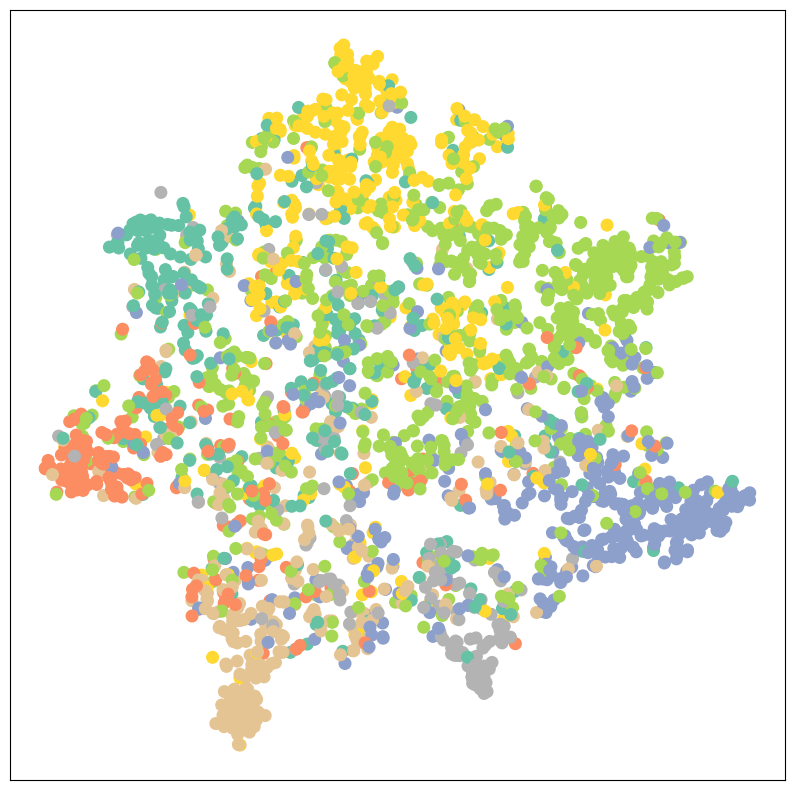

In [13]:
test_acc=test()
print(f'Test Accuracy:{test_acc:.4f}')

model.eval()
out = model(data.x)
visualize(out,color=data.y)


In [14]:
#将全连接层替换变成GCN层
from torch_geometric.nn import GCNConv
class GCN(torch. nn.Module):
    def __init__(self,hidden_channels):
        super ().__init__()
        torch. manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features,hidden_channels)
        self.conv2 = GCNConv(hidden_channels,dataset.num_classes)
    def forward(self,x, edge_index) :
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x,p=0.5,training=self.training)
        x = self.conv2(x, edge_index)
        return x
model = GCN (hidden_channels=16)
print (model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


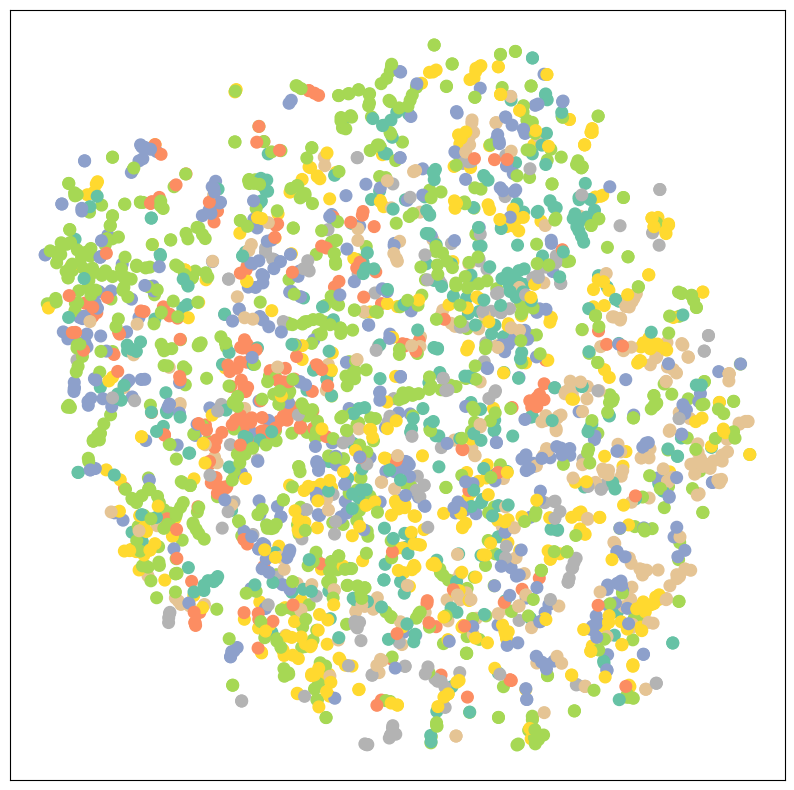

In [15]:
#可视化展示下,七分类
model = GCN(hidden_channels=16)
model.eval()
out = model(data.x,data.edge_index)
visualize(out,color=data.y)

In [16]:
model = GCN(hidden_channels=16)
criterion = torch. nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.01, weight_decay=5e-4)

def train() :
    model.train ()
    optimizer.zero_grad()#梯度清零
    out = model(data.x,data.edge_index)#前向传播多一条边
    loss = criterion(out[data.train_mask],data.y[data.train_mask])#预测损失,只考虑有标签的
    loss.backward()#反向传播
    optimizer.step()#梯度更新
    return loss
def test() :
    model.eval()
    out = model(data.x,data.edge_index)
    pred = out.argmax(dim=1)
    test_correct = pred[data.test_mask] == data.y[data.test_mask]
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
    return test_acc
for epoch in range(1,201):
    loss = train()
    print (f' Epoch: {epoch: 03d} , Loss: {loss:.4f}')

 Epoch:  01 , Loss: 1.9463
 Epoch:  02 , Loss: 1.9409
 Epoch:  03 , Loss: 1.9343
 Epoch:  04 , Loss: 1.9275
 Epoch:  05 , Loss: 1.9181
 Epoch:  06 , Loss: 1.9086
 Epoch:  07 , Loss: 1.9015
 Epoch:  08 , Loss: 1.8933
 Epoch:  09 , Loss: 1.8808
 Epoch:  10 , Loss: 1.8685
 Epoch:  11 , Loss: 1.8598
 Epoch:  12 , Loss: 1.8482
 Epoch:  13 , Loss: 1.8290
 Epoch:  14 , Loss: 1.8233
 Epoch:  15 , Loss: 1.8057
 Epoch:  16 , Loss: 1.7966
 Epoch:  17 , Loss: 1.7825
 Epoch:  18 , Loss: 1.7617
 Epoch:  19 , Loss: 1.7491
 Epoch:  20 , Loss: 1.7310
 Epoch:  21 , Loss: 1.7147
 Epoch:  22 , Loss: 1.7056
 Epoch:  23 , Loss: 1.6954
 Epoch:  24 , Loss: 1.6697
 Epoch:  25 , Loss: 1.6538
 Epoch:  26 , Loss: 1.6312
 Epoch:  27 , Loss: 1.6161
 Epoch:  28 , Loss: 1.5899
 Epoch:  29 , Loss: 1.5711
 Epoch:  30 , Loss: 1.5576
 Epoch:  31 , Loss: 1.5393
 Epoch:  32 , Loss: 1.5137
 Epoch:  33 , Loss: 1.4948
 Epoch:  34 , Loss: 1.4913
 Epoch:  35 , Loss: 1.4698
 Epoch:  36 , Loss: 1.3998
 Epoch:  37 , Loss: 1.4041
 

In [17]:
test_acc=test()
print(f'Test Accuracy:{test_acc:.4f}')

Test Accuracy:0.8020


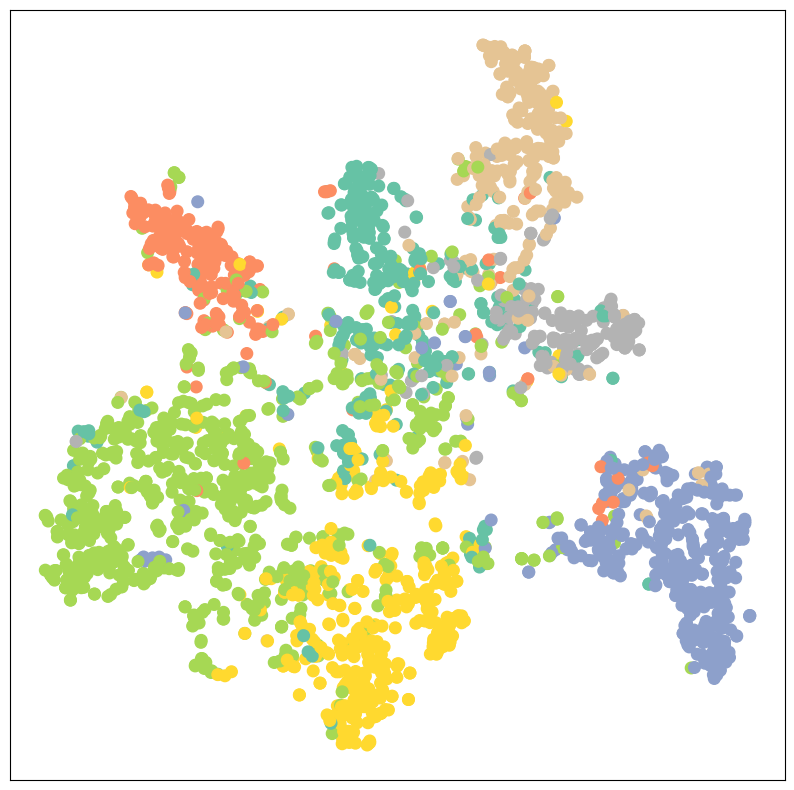

In [18]:
model.eval()
out = model(data.x,data.edge_index)
visualize(out,color=data.y)